In [1]:
%matplotlib inline
import os
from glob import glob

import numpy as np
import pandas as pd
idx = pd.IndexSlice
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

import geopandas as gpd

from sklearn.metrics import mean_absolute_error

from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor

import contextily as cx

In [2]:
data_dir = '/cluster/tufts/hugheslab/datasets/NSF_OD/'
svi_dir = os.path.join(data_dir,'SocialVulnerabilityIndex')
result_dir = os.path.join(data_dir, 'results')
mass_shapefile = os.path.join(data_dir,'shapefiles','MA_2021')

In [7]:
%% 
svi_file = os.path.join(result_dir,'svi_qtr')
svi_gdf = gpd.read_file(svi_file)

<AxesSubplot: >

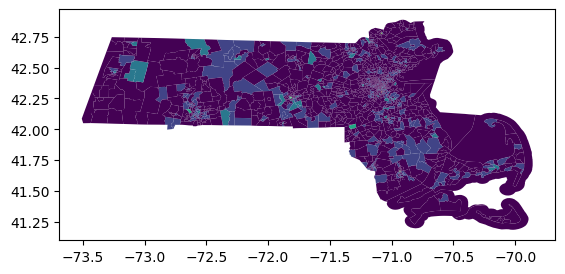

In [11]:
svi_gdf[(svi_gdf['quarter']==3)&(svi_gdf['year']==2020)].plot('deaths')

In [4]:
svi_gdf = svi_gdf.rename(columns={'INTPTLAT':'lat', 'INTPTLON':'lon', 'GEOID':'grid_squar'})
# Make lat and lon floats
svi_gdf.loc[:, 'lat'] = svi_gdf.lat.astype(float)
svi_gdf.loc[:, 'lon'] = svi_gdf.lon.astype(float)
deaths_gdf = svi_gdf

just_grid = deaths_gdf.loc[(deaths_gdf['year']==2000)&(deaths_gdf['month']==1), ['grid_squar','geometry', 'lat', 'lon']]


In [5]:
# Make lat and lon floats
deaths_gdf.loc[:, 'lat'] = deaths_gdf.lat.astype(float)
deaths_gdf.loc[:, 'lon'] = deaths_gdf.lon.astype(float)

In [6]:
from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance in kilometers between two points 
    on the earth (specified in decimal degrees)
    https://stackoverflow.com/a/4913653/1748679
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles. Determines return value units.
    return c * r

In [7]:
# Calculate each squares neighbors
neighbors = {}
for _, row in just_grid.iterrows():
    just_grid.loc[:,'haversine'] = just_grid.apply(lambda x: haversine(row['lon'], row['lat'],
                                                                         x['lon'], x['lat']),
                                                  axis=1)
    matching_neighbors = just_grid[just_grid['haversine']<5]['grid_squar'].values
    neighbors[row['grid_squar']]=matching_neighbors

In [8]:

tracts = deaths_gdf['grid_squar'].unique()
min_year = deaths_gdf.year.min()
max_year = deaths_gdf.year.max()
deaths_gdf = deaths_gdf.set_index(['grid_squar','year','month']).sort_index()

month_since_2000 = 0
season_since_2000 = 0
qtr_since_2000 = 0
for year in range(min_year, max_year+1):
    for month in range(1, 12+1):
        
        if month in [1,2,3,4,5,6]:
            season='janjun'
        else:
            season='juldec'
            
        if month <= 3:
            qtr = 1
        elif month <= 6:
            qtr = 2
        elif month <= 9:
            qtr = 3
        else:
            qtr = 4
        
        deaths_gdf.loc[idx[:,year, month], 'month_since_2000'] = month_since_2000
        deaths_gdf.loc[idx[:,year, month], 'season'] = season
        deaths_gdf.loc[idx[:,year, month], 'season_since_2000'] = season_since_2000
        deaths_gdf.loc[idx[:,year, month], 'quarter'] = qtr
        deaths_gdf.loc[idx[:,year, month], 'qtr_since_2000'] = qtr_since_2000
        
        month_since_2000+=1
        
        if month in [6, 12]:
            season_since_2000 += 1
        
        if month in [3,6,9,12]:
            qtr_since_2000 += 1
        

In [9]:
deaths_gdf = deaths_gdf.reset_index()
tracts = deaths_gdf['grid_squar'].unique()
min_year = deaths_gdf.year.min()
max_year = deaths_gdf.year.max()
deaths_gdf = deaths_gdf.set_index(['grid_squar','year','month']).sort_index()
deaths_gdf.loc[idx[:,:,:],'last_timestep'] = deaths_gdf.loc[idx[:,:,:],'deaths'].shift(1,)
deaths_gdf.loc[idx[:,:,:],'last_year'] = deaths_gdf.loc[idx[:,:,:],'deaths'].shift(12)
deaths_gdf.loc[idx[:,:,:],'delta_deaths'] = deaths_gdf.loc[idx[:,:,:],'deaths'] - deaths_gdf.loc[idx[:,:,:],'last_timestep']
for tract in tracts:
     deaths_gdf.loc[idx[tract,:,:],'neighbors_last_timestep']= \
        deaths_gdf.loc[idx[neighbors[tract],:,:],'last_timestep'].groupby(level=['year', 'month']).mean().shift(1).values
     deaths_gdf.loc[idx[tract,:,:],'neighbors_last_year']= \
        deaths_gdf.loc[idx[neighbors[tract],:,:],'last_year'].groupby(level=['year', 'month']).mean().shift(12).values
    


In [10]:
deaths_gdf

STATEFP COUNTYFP TRACTCE     NAME  \
grid_squar  year month                                     
25001010100 2000 1          25      001   10100      101   
                 2          25      001   10100      101   
                 3          25      001   10100      101   
                 4          25      001   10100      101   
                 5          25      001   10100      101   
...                        ...      ...     ...      ...   
25027761402 2021 8          25      027  761402  7614.02   
                 9          25      027  761402  7614.02   
                 10         25      027  761402  7614.02   
                 11         25      027  761402  7614.02   
                 12         25      027  761402  7614.02   

                                    NAMELSAD  MTFCC FUNCSTAT     ALAND  \
grid_squar  year month                                                   
25001010100 2000 1          Census Tract 101  G5020        S  25046216   
                 2          Census Tract 101  G5020        S  25046216   
                 3          Census Tract 101  G5020        S  25046216   
                 4          Census Tract 101  G5020        S  25046216   
                 5          Census Tract 101  G5020        S  25046216   
...                                      ...    ...      ...       ...   
25027761402 2021 8      Census Tract 7614.02  G5020        S  25568170   
                 9      Census Tract 7614.02  G5020        S  25568170   
                 10     Census Tract 7614.02  G5020        S  25568170   
                 11     Census Tract 7614.02  G5020        S  25568170   
                 12     Census Tract 7614.02  G5020        S  25568170   

                          AWATER        lat  ...  month_since_2000  season  \
grid_squar  year month                       ...                             
25001010100 2000 1      12765872  42.059829  ...               0.0  janjun   
                 2      12765872  42.059829  ...               1.0  janjun   
                 3      12765872  42.059829  ...               2.0  janjun   
                 4      12765872  42.059829  ...               3.0  janjun   
                 5      12765872  42.059829  ...               4.0  janjun   
...                          ...        ...  ...               ...     ...   
25027761402 2021 8        209089  42.531342  ...             259.0  juldec   
                 9        209089  42.531342  ...             260.0  juldec   
                 10       209089  42.531342  ...             261.0  juldec   
                 11       209089  42.531342  ...             262.0  juldec   
                 12       209089  42.531342  ...             263.0  juldec   

                        season_since_2000  quarter  qtr_since_2000  \
grid_squar  year month                                               
25001010100 2000 1                    0.0      1.0             0.0   
                 2                    0.0      1.0             0.0   
                 3                    0.0      1.0             0.0   
                 4                    0.0      2.0             1.0   
                 5                    0.0      2.0             1.0   
...                                   ...      ...             ...   
25027761402 2021 8                   43.0      3.0            86.0   
                 9                   43.0      3.0            86.0   
                 10                  43.0      4.0            87.0   
                 11                  43.0      4.0            87.0   
                 12                  43.0      4.0            87.0   

                        last_timestep  last_year  delta_deaths  \
grid_squar  year month                                           
25001010100 2000 1                NaN        NaN           NaN   
                 2                0.0        NaN           0.0   
                 3                0.0        NaN           0.0   
                 4     

In [11]:
deaths_gdf = deaths_gdf.reset_index()

In [12]:
deaths_gdf_qtr = deaths_gdf.groupby(['grid_squar','year','qtr_since_2000']).sum(min_count=3)[['deaths','delta_deaths','last_timestep','last_year', 'neighbors_last_timestep','neighbors_last_year']].reset_index()
deaths_gdf_season = deaths_gdf.groupby(['grid_squar','year','season_since_2000']).sum(min_count=6)[['deaths','delta_deaths','last_timestep','last_year', 'neighbors_last_timestep','neighbors_last_year']].reset_index()

In [13]:
deaths_gdf_qtr = deaths_gdf.groupby(['grid_squar','year','quarter','qtr_since_2000']).sum(min_count=3)[['deaths','delta_deaths','last_timestep','last_year', 'neighbors_last_timestep','neighbors_last_year']]
deaths_gdf_qtr.loc[idx[:,:,:,:],'last_timestep'] = deaths_gdf_qtr.loc[idx[:,:,:,:],'deaths'].shift(1,)
deaths_gdf_qtr.loc[idx[:,:,:,:],'last_year'] = deaths_gdf_qtr.loc[idx[:,:,:,:],'deaths'].shift(4)
deaths_gdf_qtr.loc[idx[:,:,:,:],'delta_deaths'] = deaths_gdf_qtr.loc[idx[:,:,:,:],'deaths'] - deaths_gdf_qtr.loc[idx[:,:,:,:],'last_timestep']
for tract in tracts:
     deaths_gdf_qtr.loc[idx[tract,:,:,:],'neighbors_last_timestep']= \
        deaths_gdf_qtr.loc[idx[neighbors[tract],:,:,:],'last_timestep'].groupby(level=['year', 'quarter','qtr_since_2000']).mean().shift(1).values
     deaths_gdf_qtr.loc[idx[tract,:,:,:],'neighbors_last_year']= \
        deaths_gdf_qtr.loc[idx[neighbors[tract],:,:,:],'last_year'].groupby(level=['year','quarter', 'qtr_since_2000']).mean().shift(4).values
    
deaths_gdf_qtr = deaths_gdf_qtr.reset_index()

In [14]:
deaths_gdf_season = deaths_gdf.groupby(['grid_squar','year','season','season_since_2000']).sum(min_count=6)[['deaths','delta_deaths','last_timestep','last_year', 'neighbors_last_timestep','neighbors_last_year']]
deaths_gdf_season.loc[idx[:,:,:,:],'last_timestep'] = deaths_gdf_season.loc[idx[:,:,:,:],'deaths'].shift(1,)
deaths_gdf_season.loc[idx[:,:,:,:],'last_year'] = deaths_gdf_season.loc[idx[:,:,:,:],'deaths'].shift(2)
deaths_gdf_season.loc[idx[:,:,::,],'delta_deaths'] = deaths_gdf_season.loc[idx[:,:,:,:],'deaths'] - deaths_gdf_season.loc[idx[:,:,:],'last_timestep']
for tract in tracts:
     deaths_gdf_season.loc[idx[tract,:,:,:],'neighbors_last_timestep']= \
        deaths_gdf_season.loc[idx[neighbors[tract],:,:,:],'last_timestep'].groupby(level=[ 'season_since_2000']).mean().shift(1).values
     deaths_gdf_season.loc[idx[tract,:,:,:],'neighbors_last_year']= \
        deaths_gdf_season.loc[idx[neighbors[tract],:,:,:],'last_year'].groupby(level=[ 'season_since_2000']).mean().shift(2).values
    
deaths_gdf_season = deaths_gdf_season.reset_index()

In [15]:
def top_X(y_true, y_pred, X=10):
    
    top_X_predicted = y_pred.sort_values(ascending=False)[:X]
    top_X_true = y_true.sort_values(ascending=False)[:X]
    
    undisputed_top_predicted = top_X_predicted[top_X_predicted>top_X_predicted.min()]
    num_tied_spots = X - len(undisputed_top_predicted)
    undisputed_top_true = top_X_true[top_X_true > top_X_true.min()]
    num_true_ties = X - len(undisputed_top_true)
    
    tied_top_predicted = top_X_predicted[top_X_predicted==top_X_predicted.min()]
    tied_top_true = top_X_true[top_X_true==top_X_true.min()]
    
    error_in_top_true_ties = np.abs(tied_top_true-y_pred[tied_top_true.index]).sort_values(ascending=True)
    error_in_top_pred_ties = np.abs(y_true[tied_top_predicted.index]-tied_top_predicted).sort_values(ascending=True)
    top_true_tied_geoids = error_in_top_true_ties[:num_true_ties].index
    top_pred_tied_geoids = error_in_top_pred_ties[:num_tied_spots].index

    best_possible_top_true_geoids = pd.Index.union(undisputed_top_true.index, top_true_tied_geoids)
    best_possible_top_pred_geoids = pd.Index.union(undisputed_top_predicted.index, top_pred_tied_geoids)
    
    # True values of GEOIDS with highest actual deaths. If ties, finds tied locations that match preds best
    best_possible_true = y_true[best_possible_top_true_geoids]
    best_possible_pred = y_true[best_possible_top_pred_geoids]

    assert(len(best_possible_true)==X)
    assert(len(best_possible_pred)==X)
    
    best_possible_absolute = np.abs(best_possible_true.sum() - best_possible_pred.sum())
    best_possible_ratio = np.abs(best_possible_pred).sum()/np.abs(best_possible_true).sum()
    
    
    bootstrapped_tied_indices = np.random.choice(tied_top_predicted.index, (1000, num_tied_spots))
    bootstrapped_all_indices =  [pd.Index.union(undisputed_top_predicted.index,
                                                bootstrap_index) for bootstrap_index in bootstrapped_tied_indices]
    
    bootstrapped_absolute = np.mean([np.abs(top_X_true.sum() - y_true[indices].sum()) 
                                     for indices in bootstrapped_all_indices])
    bootstrapped_ratio = np.mean([np.abs(y_true[indices]).sum()/np.abs(top_X_true).sum()
                                  for indices in bootstrapped_all_indices])
    
    return best_possible_absolute, best_possible_ratio, bootstrapped_absolute, bootstrapped_ratio

In [16]:
def top_X_old(y_true, y_pred, X=10,):
    '''Makes ugly assumptions that y_true is a df with 
    GEOID and deaths columns.
    y_pred is a series with deaths as values and GEOID as index
    '''
    
    # Check out many distinct values are in the top X
    top_values_in_preds = y_pred.sort_values()[-X:]
    lowest_predicted_top_value = top_values_in_preds.min()
    undisputed_top_preds = top_values_in_preds[top_values_in_preds>lowest_predicted_top_value]
    tied_top_preds = y_pred[y_pred==lowest_predicted_top_value]
    num_prediction_ties = len(tied_top_preds)-1
    num_tied_spots = X - len(undisputed_top_preds)
    
    top_y_true = y_true.sort_values()[-X:]
    lowest_predicted_top_true_value = top_y_true.min()
    num_true_ties = len(y_true[y_true==lowest_predicted_top_true_value])-1
    undisput
    top_true_with_ties = y_true[y_true>=lowest_predicted_top_true_value]
    
    tied_top_predicted = y_pred[y_pred.isin(tied_top_preds.values)]
    undisputed_top_predicted = y_pred[y_pred.isin(undisputed_top_preds.values)]
    
    top_true_in_undisputed_preds = y_true.loc[undisputed_top_predicted.index]
    top_true_in_tied_preds = y_true.loc[tied_top_preds.index]
    
    error_in_tied_preds = np.abs(top_true_in_tied_preds-tied_top_preds).sort_values(ascending=True)
    best_tied_preds = error_in_tied_preds[:num_tied_spots]
    best_possible_preds = pd.concat((undisputed_top_preds, tied_top_preds.loc[best_tied_preds.index]))
    best_possible_true_preds = pd.concat((top_true_in_undisputed_preds, top_true_in_tied_preds.loc[best_tied_preds.index]))

    bootstrapped_predicted_indices = np.random.choice(tied_top_predicted.index, (1000, num_tied_spots))
    bootstrapped_tied_preds = [pd.concat((undisputed_top_preds,
                                          tied_top_predicted[bootstrap_index]))
                               for bootstrap_index in bootstrapped_predicted_indices]
    bootstrapped_tied_true_preds = [pd.concat((top_true_in_undisputed_preds,
                                               top_true_in_tied_preds[bootstrap_index]))
                                    for bootstrap_index in bootstrapped_predicted_indices]
                                              
    assert(np.all([len(preds)==X for preds in bootstrapped_tied_preds]))
    assert(np.all([len(preds)==X for preds in bootstrapped_tied_true_preds]))
                                              
    
    
    best_possible_absolute = np.abs(best_possible_true_preds - best_possible_preds).sum()
    best_possible_ratio = best_possible_preds.sum()/best_possible_true_preds.sum()
    
    
    bootstrapped_absolute = np.mean([np.abs(true_preds - preds).sum() 
                                     for true_preds, preds in zip(bootstrapped_tied_true_preds, bootstrapped_tied_preds)])
    bootstrapped_ratio = np.mean([preds.sum()/true_preds.sum()
                                  for true_preds, preds in zip(bootstrapped_tied_true_preds, bootstrapped_tied_preds)])
    
    
    
    return best_possible_absolute, best_possible_ratio, bootstrapped_absolute, bootstrapped_ratio, num_tied_spots

## Monthly

In [ ]:
monthly_through_2018 = deaths_gdf[(~deaths_gdf['last_timestep'].isna()) &
                                  (deaths_gdf['year']<2019)]
monthly_2019 = deaths_gdf[deaths_gdf['year']==2019]

In [ ]:
monthly_2019_self_preds = monthly_2019['last_timestep']

In [ ]:
val = np.abs(monthly_2019['deaths']-monthly_2019['last_timestep']).mean()
print(f'Mean Abs Error using last month {val}')

val = np.median(np.abs(monthly_2019['deaths'] - monthly_2019['last_timestep']))
print(f'Median Abs Error using last month {val}')

val = np.quantile(np.abs(monthly_2019['deaths'].values-monthly_2019['last_timestep']), 0.90)
print(f'90th %ile Abs Error using last month {val}')

val = np.abs(monthly_2019['deaths']-monthly_2019['last_year']).mean()
print(f'Mean Abs Error using last year {val}')

val = np.median(np.abs(monthly_2019['deaths'] - monthly_2019['last_year']))
print(f'Median Abs Error using last year {val}')

val = np.quantile(np.abs(monthly_2019['deaths'] - monthly_2019['last_year']), 0.90)
print(f'90th %ile Abs Error using last year {val}')

In [ ]:
val = np.abs(monthly_2019['deaths']-monthly_2019['neighbors_last_timestep']).mean()
print(f'Mean Abs Error using neighbors last month {val}')

val = np.median(np.abs(monthly_2019['deaths'] - monthly_2019['neighbors_last_timestep']))
print(f'Median Abs Error using neighbors  last month {val}')

val = np.quantile(np.abs(monthly_2019['deaths'].values-monthly_2019['neighbors_last_timestep']), 0.90)
print(f'90th %ile Abs Error using neighbors  last month {val}')

val = np.abs(monthly_2019['deaths']-monthly_2019['neighbors_last_year']).mean()
print(f'Mean Abs Error using neighbors last year {val}')

val = np.median(np.abs(monthly_2019['deaths'] - monthly_2019['neighbors_last_year']))
print(f'Median Abs Error using neighbors last year {val}')

val = np.quantile(np.abs(monthly_2019['deaths'] - monthly_2019['neighbors_last_year']), 0.90)
print(f'90th %ile Abs Error using neighbors last year {val}')

In [ ]:
best_abs = []
best_ratio = []
boot_abs = []
boot_ratio = []
for month in range(1,12+1):
    this_month_true = monthly_2019[monthly_2019['month']==month].set_index('grid_squar')['deaths']
    this_month_pred = monthly_2019[monthly_2019['month']==month].set_index('grid_squar')['last_timestep']
    be_a, be_r, bo_a, bo_r = top_X(this_month_true, this_month_pred)
    best_abs.append(be_a)
    best_ratio.append(be_r)
    boot_abs.append(bo_a)
    boot_ratio.append(bo_r)
    
print(f'Best abs diff: {np.mean(best_abs)}')
print(f'Best ratio: {np.mean(best_ratio)}')
print(f'Boot abs diff: {np.mean(boot_abs)}')
print(f'Boot ratio: {np.mean(boot_ratio)}')

In [ ]:
best_abs = []
best_ratio = []
boot_abs = []
boot_ratio = []
for month in range(1,12+1):
    this_month_true = monthly_2019[monthly_2019['month']==month].set_index('grid_squar')['deaths']
    this_month_pred = monthly_2019[monthly_2019['month']==month].set_index('grid_squar')['last_year']
    be_a, be_r, bo_a, bo_r = top_X(this_month_true, this_month_pred)
    best_abs.append(be_a)
    best_ratio.append(be_r)
    boot_abs.append(bo_a)
    boot_ratio.append(bo_r)
    
print(f'Best abs diff: {np.mean(best_abs)}')
print(f'Best ratio: {np.mean(best_ratio)}')
print(f'Boot abs diff: {np.mean(boot_abs)}')
print(f'Boot ratio: {np.mean(boot_ratio)}')

In [ ]:
best_abs = []
best_ratio = []
boot_abs = []
boot_ratio = []
for month in range(1,12+1):
    this_month_true = monthly_2019[monthly_2019['month']==month].set_index('grid_squar')['deaths']
    this_month_pred = monthly_2019[monthly_2019['month']==month].set_index('grid_squar')['neighbors_last_timestep']
    be_a, be_r, bo_a, bo_r = top_X(this_month_true, this_month_pred)
    best_abs.append(be_a)
    best_ratio.append(be_r)
    boot_abs.append(bo_a)
    boot_ratio.append(bo_r)
    
print(f'Best abs diff: {np.mean(best_abs)}')
print(f'Best ratio: {np.mean(best_ratio)}')
print(f'Boot abs diff: {np.mean(boot_abs)}')
print(f'Boot ratio: {np.mean(boot_ratio)}')

In [ ]:
best_abs = []
best_ratio = []
boot_abs = []
boot_ratio = []
for month in range(1,12+1):
    this_month_true = monthly_2019[monthly_2019['month']==month].set_index('grid_squar')['deaths']
    this_month_pred = monthly_2019[monthly_2019['month']==month].set_index('grid_squar')['neighbors_last_year']
    be_a, be_r, bo_a, bo_r = top_X(this_month_true, this_month_pred)
    best_abs.append(be_a)
    best_ratio.append(be_r)
    boot_abs.append(bo_a)
    boot_ratio.append(bo_r)
    
print(f'Best abs diff: {np.mean(best_abs)}')
print(f'Best ratio: {np.mean(best_ratio)}')
print(f'Boot abs diff: {np.mean(boot_abs)}')
print(f'Boot ratio: {np.mean(boot_ratio)}')

In [ ]:
best_abs = []
best_ratio = []
boot_abs = []
boot_ratio = []
for month in range(1,12+1):
    this_month_true = monthly_2019[monthly_2019['month']==month].set_index('grid_squar')['deaths']
    this_month_pred = monthly_2019[monthly_2019['month']==month].set_index('grid_squar')['last_timestep']
    be_a, be_r, bo_a, bo_r = top_X(this_month_true, this_month_pred, 100)
    best_abs.append(be_a)
    best_ratio.append(be_r)
    boot_abs.append(bo_a)
    boot_ratio.append(bo_r)
    
print(f'Best abs diff: {np.mean(best_abs)}')
print(f'Best ratio: {np.mean(best_ratio)}')
print(f'Boot abs diff: {np.mean(boot_abs)}')
print(f'Boot ratio: {np.mean(boot_ratio)}')

In [ ]:
best_abs = []
best_ratio = []
boot_abs = []
boot_ratio = []
for month in range(1,12+1):
    this_month_true = monthly_2019[monthly_2019['month']==month].set_index('grid_squar')['deaths']
    this_month_pred = monthly_2019[monthly_2019['month']==month].set_index('grid_squar')['last_year']
    be_a, be_r, bo_a, bo_r = top_X(this_month_true, this_month_pred, 100)
    best_abs.append(be_a)
    best_ratio.append(be_r)
    boot_abs.append(bo_a)
    boot_ratio.append(bo_r)
    
print(f'Best abs diff: {np.mean(best_abs)}')
print(f'Best ratio: {np.mean(best_ratio)}')
print(f'Boot abs diff: {np.mean(boot_abs)}')
print(f'Boot ratio: {np.mean(boot_ratio)}')

In [ ]:
best_abs = []
best_ratio = []
boot_abs = []
boot_ratio = []
for month in range(1,12+1):
    this_month_true = monthly_2019[monthly_2019['month']==month].set_index('grid_squar')['deaths']
    this_month_pred = monthly_2019[monthly_2019['month']==month].set_index('grid_squar')['neighbors_last_timestep']
    be_a, be_r, bo_a, bo_r = top_X(this_month_true, this_month_pred, 100)
    best_abs.append(be_a)
    best_ratio.append(be_r)
    boot_abs.append(bo_a)
    boot_ratio.append(bo_r)
    
print(f'Best abs diff: {np.mean(best_abs)}')
print(f'Best ratio: {np.mean(best_ratio)}')
print(f'Boot abs diff: {np.mean(boot_abs)}')
print(f'Boot ratio: {np.mean(boot_ratio)}')

best_abs = []
best_ratio = []
boot_abs = []
boot_ratio = []
for month in range(1,12+1):
    this_month_true = monthly_2019[monthly_2019['month']==month].set_index('grid_squar')['deaths']
    this_month_pred = monthly_2019[monthly_2019['month']==month].set_index('grid_squar')['neighbors_last_year']
    be_a, be_r, bo_a, bo_r = top_X(this_month_true, this_month_pred, 100)
    best_abs.append(be_a)
    best_ratio.append(be_r)
    boot_abs.append(bo_a)
    boot_ratio.append(bo_r)
    
print(f'Best abs diff: {np.mean(best_abs)}')
print(f'Best ratio: {np.mean(best_ratio)}')
print(f'Boot abs diff: {np.mean(boot_abs)}')
print(f'Boot ratio: {np.mean(boot_ratio)}')

## Quarterly

In [25]:
qtr_through_2018 = deaths_gdf_qtr[(~deaths_gdf_qtr['last_timestep'].isna()) &
                                  (deaths_gdf_qtr['year']<2019)]
qtr_2019 = deaths_gdf_qtr[deaths_gdf_qtr['year']==2019]


In [26]:
val = np.abs(qtr_2019['deaths']-qtr_2019['last_timestep']).mean()
print(f'Mean Abs Error using last month {val}')

val = np.median(np.abs(qtr_2019['deaths'] - qtr_2019['last_timestep']))
print(f'Median Abs Error using last month {val}')

val = np.quantile(np.abs(qtr_2019['deaths'].values-qtr_2019['last_timestep']), 0.90)
print(f'90th %ile Abs Error using last month {val}')

val = np.abs(qtr_2019['deaths']-qtr_2019['last_year']).mean()
print(f'Mean Abs Error using last year {val}')

val = np.median(np.abs(qtr_2019['deaths'] - qtr_2019['last_year']))
print(f'Median Abs Error using last year {val}')

val = np.quantile(np.abs(qtr_2019['deaths'] - qtr_2019['last_year']), 0.90)
print(f'90th %ile Abs Error using last year {val}')

val = np.abs(qtr_2019['deaths']-qtr_2019['neighbors_last_timestep']).mean()
print(f'Mean Abs Error using neighbors last month {val}')

val = np.median(np.abs(qtr_2019['deaths'] - qtr_2019['neighbors_last_timestep']))
print(f'Median Abs Error using neighbors  last month {val}')

val = np.quantile(np.abs(qtr_2019['deaths'].values-qtr_2019['neighbors_last_timestep']), 0.90)
print(f'90th %ile Abs Error using neighbors  last month {val}')

val = np.abs(qtr_2019['deaths']-qtr_2019['neighbors_last_year']).mean()
print(f'Mean Abs Error using neighbors last year {val}')

val = np.median(np.abs(qtr_2019['deaths'] - qtr_2019['neighbors_last_year']))
print(f'Median Abs Error using neighbors last year {val}')

val = np.quantile(np.abs(qtr_2019['deaths'] - qtr_2019['neighbors_last_year']), 0.90)
print(f'90th %ile Abs Error using neighbors last year {val}')

Mean Abs Error using last month 0.4070987654320988
Median Abs Error using last month 0.0
90th %ile Abs Error using last month 1.0
Mean Abs Error using last year 0.41790123456790124
Median Abs Error using last year 0.0
90th %ile Abs Error using last year 1.0
Mean Abs Error using neighbors last month 0.40537207059540203
Median Abs Error using neighbors  last month 0.2857142857142857
90th %ile Abs Error using neighbors  last month 0.8618854396470219
Mean Abs Error using neighbors last year 0.4044491250886217
Median Abs Error using neighbors last year 0.2857142857142857
90th %ile Abs Error using neighbors last year 0.875


In [28]:
best_abs = []
best_ratio = []
boot_abs = []
boot_ratio = []
for quarter in range(1,4+1):
    this_month_true = qtr_2019[qtr_2019['quarter']==quarter].set_index('grid_squar')['deaths']
    this_month_pred = qtr_2019[qtr_2019['quarter']==quarter].set_index('grid_squar')['last_timestep']
    be_a, be_r, bo_a, bo_r = top_X(this_month_true, this_month_pred)
    best_abs.append(be_a)
    best_ratio.append(be_r)
    boot_abs.append(bo_a)
    boot_ratio.append(bo_r)
    
print(f'Best abs diff: {np.mean(best_abs)}')
print(f'Best ratio: {np.mean(best_ratio)}')
print(f'Boot abs diff: {np.mean(boot_abs)}')
print(f'Boot ratio: {np.mean(boot_ratio)}')

best_abs = []
best_ratio = []
boot_abs = []
boot_ratio = []
for quarter in range(1,4+1):
    this_month_true = qtr_2019[qtr_2019['quarter']==quarter].set_index('grid_squar')['deaths']
    this_month_pred = qtr_2019[qtr_2019['quarter']==quarter].set_index('grid_squar')['last_timestep']
    be_a, be_r, bo_a, bo_r = top_X(this_month_true, this_month_pred, int(1602*0.2))
    best_abs.append(be_a)
    best_ratio.append(be_r)
    boot_abs.append(bo_a)
    boot_ratio.append(bo_r)
    
print(f'Best abs diff: {np.mean(best_abs)}')
print(f'Best ratio: {np.mean(best_ratio)}')
print(f'Boot abs diff: {np.mean(boot_abs)}')
print(f'Boot ratio: {np.mean(boot_ratio)}')

Best abs diff: 26.0
Best ratio: 0.14666982323232325
Boot abs diff: 26.05325
Boot ratio: 0.14502437394781145
Best abs diff: 265.5
Best ratio: 0.33093803307358294
Boot abs diff: 265.4075
Boot ratio: 0.3311721071417379


In [25]:
best_abs = []
best_ratio = []
boot_abs = []
boot_ratio = []
for month in range(1,4+1):
    this_month_true = qtr_2019[qtr_2019['quarter']==quarter].set_index('grid_squar')['deaths']
    this_month_pred = qtr_2019[qtr_2019['quarter']==quarter].set_index('grid_squar')['last_year']
    be_a, be_r, bo_a, bo_r = top_X(this_month_true, this_month_pred)
    best_abs.append(be_a)
    best_ratio.append(be_r)
    boot_abs.append(bo_a)
    boot_ratio.append(bo_r)
    
print(f'Best abs diff: {np.mean(best_abs)}')
print(f'Best ratio: {np.mean(best_ratio)}')
print(f'Boot abs diff: {np.mean(boot_abs)}')
print(f'Boot ratio: {np.mean(boot_ratio)}')

best_abs = []
best_ratio = []
boot_abs = []
boot_ratio = []

mae = []
for quarter in range(1,4+1):
    this_month_true = qtr_2019[qtr_2019['quarter']==quarter].set_index('grid_squar')['deaths']
    this_month_pred = qtr_2019[qtr_2019['quarter']==quarter].set_index('grid_squar')['last_year']
    be_a, be_r, bo_a, bo_r = top_X(this_month_true, this_month_pred, 100)
    best_abs.append(be_a)
    best_ratio.append(be_r)
    boot_abs.append(bo_a)
    boot_ratio.append(bo_r)
    
print(f'Best abs diff: {np.mean(best_abs)}')
print(f'Best ratio: {np.mean(best_ratio)}')
print(f'Boot abs diff: {np.mean(boot_abs)}')
print(f'Boot ratio: {np.mean(boot_ratio)}')

Best abs diff: 25.0
Best ratio: 0.16666666666666666
Boot abs diff: 25.04475
Boot ratio: 0.16517500000000002
Best abs diff: 129.0
Best ratio: 0.2714333739875535
Boot abs diff: 129.102
Boot ratio: 0.270881465584639


In [26]:
best_abs = []
best_ratio = []
boot_abs = []
boot_ratio = []
for month in range(1,4+1):
    this_month_true = qtr_2019[qtr_2019['quarter']==quarter].set_index('grid_squar')['deaths']
    this_month_pred = qtr_2019[qtr_2019['quarter']==quarter].set_index('grid_squar')['neighbors_last_timestep']
    be_a, be_r, bo_a, bo_r = top_X(this_month_true, this_month_pred)
    best_abs.append(be_a)
    best_ratio.append(be_r)
    boot_abs.append(bo_a)
    boot_ratio.append(bo_r)
    
print(f'Best abs diff: {np.mean(best_abs)}')
print(f'Best ratio: {np.mean(best_ratio)}')
print(f'Boot abs diff: {np.mean(boot_abs)}')
print(f'Boot ratio: {np.mean(boot_ratio)}')

best_abs = []
best_ratio = []
boot_abs = []
boot_ratio = []
for quarter in range(1,4+1):
    this_month_true = qtr_2019[qtr_2019['quarter']==quarter].set_index('grid_squar')['deaths']
    this_month_pred = qtr_2019[qtr_2019['quarter']==quarter].set_index('grid_squar')['neighbors_last_timestep']
    be_a, be_r, bo_a, bo_r = top_X(this_month_true, this_month_pred, 100)
    best_abs.append(be_a)
    best_ratio.append(be_r)
    boot_abs.append(bo_a)
    boot_ratio.append(bo_r)
    
print(f'Best abs diff: {np.mean(best_abs)}')
print(f'Best ratio: {np.mean(best_ratio)}')
print(f'Boot abs diff: {np.mean(boot_abs)}')
print(f'Boot ratio: {np.mean(boot_ratio)}')

Best abs diff: 26.0
Best ratio: 0.13333333333333333
Boot abs diff: 26.029
Boot ratio: 0.1323666666666667
Best abs diff: 137.0
Best ratio: 0.225960455952716
Boot abs diff: 137.00675
Boot ratio: 0.22592435969603153


In [ ]:
best_abs = []
best_ratio = []
boot_abs = []
boot_ratio = []
for month in range(1,4+1):
    this_month_true = qtr_2019[qtr_2019['quarter']==quarter].set_index('grid_squar')['deaths']
    this_month_pred = qtr_2019[qtr_2019['quarter']==quarter].set_index('grid_squar')['neighbors_last_year']
    be_a, be_r, bo_a, bo_r = top_X(this_month_true, this_month_pred)
    best_abs.append(be_a)
    best_ratio.append(be_r)
    boot_abs.append(bo_a)
    boot_ratio.append(bo_r)
    
print(f'Best abs diff: {np.mean(best_abs)}')
print(f'Best ratio: {np.mean(best_ratio)}')
print(f'Boot abs diff: {np.mean(boot_abs)}')
print(f'Boot ratio: {np.mean(boot_ratio)}')

best_abs = []
best_ratio = []
boot_abs = []
boot_ratio = []
for quarter in range(1,4+1):
    this_month_true = qtr_2019[qtr_2019['quarter']==quarter].set_index('grid_squar')['deaths']
    this_month_pred = qtr_2019[qtr_2019['quarter']==quarter].set_index('grid_squar')['neighbors_last_year']
    be_a, be_r, bo_a, bo_r = top_X(this_month_true, this_month_pred, 100)
    best_abs.append(be_a)
    best_ratio.append(be_r)
    boot_abs.append(bo_a)
    boot_ratio.append(bo_r)
    
print(f'Best abs diff: {np.mean(best_abs)}')
print(f'Best ratio: {np.mean(best_ratio)}')
print(f'Boot abs diff: {np.mean(boot_abs)}')
print(f'Boot ratio: {np.mean(boot_ratio)}')

## biannual

In [17]:
season_through_2018 = deaths_gdf_season[(~deaths_gdf_season['last_timestep'].isna()) &
                                  (deaths_gdf_season['year']<2019)]
season_2019 = deaths_gdf_season[deaths_gdf_season['year']==2019]


In [18]:
val = np.abs(season_2019['deaths']-season_2019['last_timestep']).mean()
print(f'Mean Abs Error using last month {val}')

val = np.median(np.abs(season_2019['deaths'] - season_2019['last_timestep']))
print(f'Median Abs Error using last month {val}')

val = np.quantile(np.abs(season_2019['deaths'].values-season_2019['last_timestep']), 0.90)
print(f'90th %ile Abs Error using last month {val}')

val = np.abs(season_2019['deaths']-season_2019['last_year']).mean()
print(f'Mean Abs Error using last year {val}')

val = np.median(np.abs(season_2019['deaths'] - season_2019['last_year']))
print(f'Median Abs Error using last year {val}')

val = np.quantile(np.abs(season_2019['deaths'] - season_2019['last_year']), 0.90)
print(f'90th %ile Abs Error using last year {val}')

val = np.abs(season_2019['deaths']-season_2019['neighbors_last_timestep']).mean()
print(f'Mean Abs Error using neighbors last month {val}')

val = np.median(np.abs(season_2019['deaths'] - season_2019['neighbors_last_timestep']))
print(f'Median Abs Error using neighbors  last month {val}')

val = np.quantile(np.abs(season_2019['deaths'].values-season_2019['neighbors_last_timestep']), 0.90)
print(f'90th %ile Abs Error using neighbors  last month {val}')

val = np.abs(season_2019['deaths']-season_2019['neighbors_last_year']).mean()
print(f'Mean Abs Error using neighbors last year {val}')

val = np.median(np.abs(season_2019['deaths'] - season_2019['neighbors_last_year']))
print(f'Median Abs Error using neighbors last year {val}')

val = np.quantile(np.abs(season_2019['deaths'] - season_2019['neighbors_last_year']), 0.90)
print(f'90th %ile Abs Error using neighbors last year {val}')

Mean Abs Error using last month 0.6574074074074074
Median Abs Error using last month 0.0
90th %ile Abs Error using last month 2.0
Mean Abs Error using last year 0.6790123456790124
Median Abs Error using last year 0.0
90th %ile Abs Error using last year 2.0
Mean Abs Error using neighbors last month 0.6390903058081759
Median Abs Error using neighbors  last month 0.5
90th %ile Abs Error using neighbors  last month 1.25
Mean Abs Error using neighbors last year 0.6243528032217335
Median Abs Error using neighbors last year 0.5
90th %ile Abs Error using neighbors last year 1.2695804195804192


In [22]:
best_abs = []
best_ratio = []
boot_abs = []
boot_ratio = []
for season in ['janjun', 'juldec']:
    this_month_true = season_2019[season_2019['season']==season].set_index('grid_squar')['deaths']
    this_month_pred = season_2019[season_2019['season']==season].set_index('grid_squar')['last_timestep']
    be_a, be_r, bo_a, bo_r = top_X(this_month_true, this_month_pred)
    best_abs.append(be_a)
    best_ratio.append(be_r)
    boot_abs.append(bo_a)
    boot_ratio.append(bo_r)
    
print(f'Best abs diff: {np.mean(best_abs)}')
print(f'Best ratio: {np.mean(best_ratio)}')
print(f'Boot abs diff: {np.mean(boot_abs)}')
print(f'Boot ratio: {np.mean(boot_ratio)}')

best_abs = []
best_ratio = []
boot_abs = []
boot_ratio = []
for season in ['janjun', 'juldec']:
    this_month_true = season_2019[season_2019['season']==season].set_index('grid_squar')['deaths']
    this_month_pred = season_2019[season_2019['season']==season].set_index('grid_squar')['last_timestep']
    be_a, be_r, bo_a, bo_r = top_X(this_month_true, this_month_pred, 100)
    best_abs.append(be_a)
    best_ratio.append(be_r)
    boot_abs.append(bo_a)
    boot_ratio.append(bo_r)
    
print(f'Best abs diff: {np.mean(best_abs)}')
print(f'Best ratio: {np.mean(best_ratio)}')
print(f'Boot abs diff: {np.mean(boot_abs)}')
print(f'Boot ratio: {np.mean(boot_ratio)}')

Best abs diff: 28.5
Best ratio: 0.31002331002331
Boot abs diff: 28.4905
Boot ratio: 0.31018822843822846
Best abs diff: 162.5
Best ratio: 0.39672400011025666
Boot abs diff: 162.50150000000002
Boot ratio: 0.39672387607155657


In [24]:
best_abs = []
best_ratio = []
boot_abs = []
boot_ratio = []
for season in ['janjun', 'juldec']:
    this_month_true = season_2019[season_2019['season']==season].set_index('grid_squar')['deaths']
    this_month_pred = season_2019[season_2019['season']==season].set_index('grid_squar')['last_year']
    be_a, be_r, bo_a, bo_r = top_X(this_month_true, this_month_pred)
    best_abs.append(be_a)
    best_ratio.append(be_r)
    boot_abs.append(bo_a)
    boot_ratio.append(bo_r)
    
print(f'Best abs diff: {np.mean(best_abs)}')
print(f'Best ratio: {np.mean(best_ratio)}')
print(f'Boot abs diff: {np.mean(boot_abs)}')
print(f'Boot ratio: {np.mean(boot_ratio)}')

best_abs = []
best_ratio = []
boot_abs = []
boot_ratio = []
for season in ['janjun', 'juldec']:
    this_month_true = season_2019[season_2019['season']==season].set_index('grid_squar')['deaths']
    this_month_pred = season_2019[season_2019['season']==season].set_index('grid_squar')['last_year']
    be_a, be_r, bo_a, bo_r = top_X(this_month_true, this_month_pred, int(1602*0.2))
    best_abs.append(be_a)
    best_ratio.append(be_r)
    boot_abs.append(bo_a)
    boot_ratio.append(bo_r)
    
print(f'Best abs diff: {np.mean(best_abs)}')
print(f'Best ratio: {np.mean(best_ratio)}')
print(f'Boot abs diff: {np.mean(boot_abs)}')
print(f'Boot ratio: {np.mean(boot_ratio)}')

Best abs diff: 324.0
Best ratio: 0.45502141837220367
Boot abs diff: 323.96799999999996
Boot ratio: 0.4550686152852383


In [35]:
best_abs = []
best_ratio = []
boot_abs = []
boot_ratio = []
for season in ['janjun', 'juldec']:
    this_month_true = season_2019[season_2019['season']==season].set_index('grid_squar')['deaths']
    this_month_pred = season_2019[season_2019['season']==season].set_index('grid_squar')['neighbors_last_timestep']
    be_a, be_r, bo_a, bo_r = top_X(this_month_true, this_month_pred)
    best_abs.append(be_a)
    best_ratio.append(be_r)
    boot_abs.append(bo_a)
    boot_ratio.append(bo_r)
    
print(f'Best abs diff: {np.mean(best_abs)}')
print(f'Best ratio: {np.mean(best_ratio)}')
print(f'Boot abs diff: {np.mean(boot_abs)}')
print(f'Boot ratio: {np.mean(boot_ratio)}')

best_abs = []
best_ratio = []
boot_abs = []
boot_ratio = []
for season in ['janjun', 'juldec']:
    this_month_true = season_2019[season_2019['season']==season].set_index('grid_squar')['deaths']
    this_month_pred = season_2019[season_2019['season']==season].set_index('grid_squar')['neighbors_last_timestep']
    be_a, be_r, bo_a, bo_r = top_X(this_month_true, this_month_pred, 100)
    best_abs.append(be_a)
    best_ratio.append(be_r)
    boot_abs.append(bo_a)
    boot_ratio.append(bo_r)
    
print(f'Best abs diff: {np.mean(best_abs)}')
print(f'Best ratio: {np.mean(best_ratio)}')
print(f'Boot abs diff: {np.mean(boot_abs)}')
print(f'Boot ratio: {np.mean(boot_ratio)}')

Best abs diff: 32.0
Best ratio: 0.2363053613053613
Boot abs diff: 32.019999999999996
Boot ratio: 0.2357400932400932
Best abs diff: 188.5
Best ratio: 0.3022616389646903
Boot abs diff: 188.53449999999998
Boot ratio: 0.3021390611648612


In [36]:
best_abs = []
best_ratio = []
boot_abs = []
boot_ratio = []
for season in ['janjun', 'juldec']:
    this_month_true = season_2019[season_2019['season']==season].set_index('grid_squar')['deaths']
    this_month_pred = season_2019[season_2019['season']==season].set_index('grid_squar')['neighbors_last_year']
    be_a, be_r, bo_a, bo_r = top_X(this_month_true, this_month_pred)
    best_abs.append(be_a)
    best_ratio.append(be_r)
    boot_abs.append(bo_a)
    boot_ratio.append(bo_r)
    
print(f'Best abs diff: {np.mean(best_abs)}')
print(f'Best ratio: {np.mean(best_ratio)}')
print(f'Boot abs diff: {np.mean(boot_abs)}')
print(f'Boot ratio: {np.mean(boot_ratio)}')

best_abs = []
best_ratio = []
boot_abs = []
boot_ratio = []
for season in ['janjun', 'juldec']:
    this_month_true = season_2019[season_2019['season']==season].set_index('grid_squar')['deaths']
    this_month_pred = season_2019[season_2019['season']==season].set_index('grid_squar')['neighbors_last_year']
    be_a, be_r, bo_a, bo_r = top_X(this_month_true, this_month_pred, 100)
    best_abs.append(be_a)
    best_ratio.append(be_r)
    boot_abs.append(bo_a)
    boot_ratio.append(bo_r)
    
print(f'Best abs diff: {np.mean(best_abs)}')
print(f'Best ratio: {np.mean(best_ratio)}')
print(f'Boot abs diff: {np.mean(boot_abs)}')
print(f'Boot ratio: {np.mean(boot_ratio)}')

Best abs diff: 32.5
Best ratio: 0.22057109557109555
Boot abs diff: 32.4345
Boot ratio: 0.22205099067599068
Best abs diff: 185.5
Best ratio: 0.3110614956310813
Boot abs diff: 185.526
Boot ratio: 0.31096984481380413
